In [1]:
# Get the data from the parquet file

from pyspark.sql import SparkSession
# memory issues .. see https://stackoverflow.com/questions/21138751/spark-java-lang-outofmemoryerror-java-heap-space
spark = SparkSession.builder.master("local[*]") \
    .config("spark.executor.memory", "12g") \
    .config("spark.driver.memory", "12g") \
    .config("spark.memory.offHeap.enabled", True).config("spark.memory.offHeap.size","8g") \
    .appName("PropertyData").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark
df = spark.read.parquet("/tmp/spark/tarrant-tx.parquet")

# Property used to format output tables better
# spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/20 17:12:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator

subset = [
    'Account_Num',  # <-- used later for analysis correlating to the original dataframe
    'Total_Value', 'Appraised_Value_Int', 'Swimming_Pool_Ind_bin'
]

# large DF causes "java.lang.NegativeArraySizeException"
logistic_df = df.select(*subset)
# and keep only those rows that are residential properties in a certain value range
logistic_df = logistic_df.where("(Total_Value between 100000 and 500000) and (RP = 'R')").limit(100)

logistic_features = ['Total_Value', 'Swimming_Pool_Ind_bin']

model_logistic = LogisticRegression(featuresCol="features", labelCol="Appraised_Value_Int", maxIter=2)

# Train
assembler = VectorAssembler(inputCols=logistic_features, outputCol='features')
train_logistic, test_logistic = assembler.transform(logistic_df).randomSplit([0.5, 0.5])
logistic_trained_model = model_logistic.fit(train_logistic)

# Evaluate
predictions = logistic_trained_model.transform(test_logistic)
evaluator = BinaryClassificationEvaluator(labelCol='Appraised_Value_Int', rawPredictionCol='prediction')
accuracy = evaluator.evaluate(predictions)

# Print the accuracy
print(f"Accuracy: {accuracy}")

23/06/20 17:12:19 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
23/06/20 17:20:02 WARN DAGScheduler: Broadcasting large task binary with size 11.2 MiB


Accuracy: 1.0


In [3]:
from pyspark.sql.functions import col
from udfs import percent_diff_udf

# cast the predictions to integer and show the difference as integer and percentage
predictions = predictions.withColumn('prediction_int', predictions['prediction'].cast('int'))
predictions = predictions.drop('prediction')
predictions = predictions.withColumn('diff', col('Appraised_Value_Int') - col('prediction_int'))
predictions = predictions.withColumn('diff_percent', percent_diff_udf(col('prediction_int'), col('Appraised_Value_Int')))

# create the views
predictions.select('Account_Num', 'prediction_int', 'diff', 'diff_percent').createOrReplaceTempView("predictions")
df.createOrReplaceTempView("data")

23/06/20 17:26:33 WARN DAGScheduler: Broadcasting large task binary with size 11.2 MiB
23/06/20 17:26:36 WARN DAGScheduler: Broadcasting large task binary with size 11.2 MiB
23/06/20 17:26:36 WARN DAGScheduler: Broadcasting large task binary with size 11.2 MiB
23/06/20 17:26:36 WARN DAGScheduler: Broadcasting large task binary with size 11.2 MiB
23/06/20 17:26:36 WARN DAGScheduler: Broadcasting large task binary with size 11.2 MiB


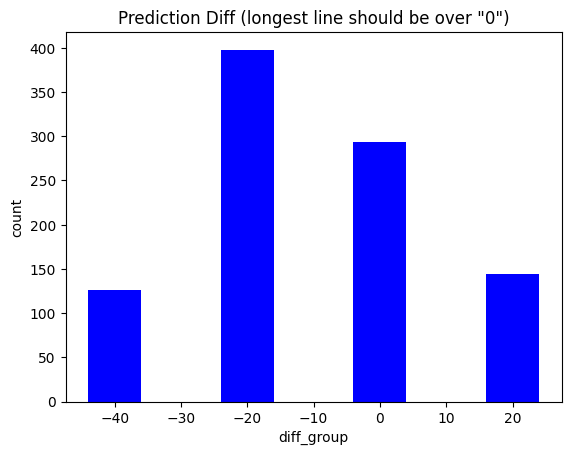

In [6]:
# let's take a look at some of the data
# we group the diff_percent values so there aren't too many records to graph
# also, here we are just looking at residential properties

query = """
with summary as (
  with src as (
    select FLOOR(CAST(diff_percent as INT) / 20) * 20 AS diff_group
    from predictions
    join data on data.Account_Num = predictions.Account_Num
  )
  select count(diff_group) as count, diff_group from src group by 2 order by 2 desc
)
select count, diff_group from summary where count > 100
"""
res = spark.sql(query)

# graph it show how the predictions differ from the current appraisal values
import matplotlib.pyplot as plt
pandas_df = res.toPandas()
plt.bar(pandas_df['diff_group'], pandas_df['count'], color='blue', width=8)
plt.xlabel('diff_group')
plt.ylabel('count')
plt.title('Prediction Diff (longest line should be over "0")') # .. which would indicate more accurate prediction
plt.show()